In this Python notebook, we will be extracting the URLs to many different Wikipedia pages then using those URLs to extract all the sentences from those same Wikipedia pages. The sentences will then be cleaned, explored, and used to train a predictive language model. We will start by extracting all the URLs we want. 

In [226]:
"""This first section collects the URLs that we will use to gather our data. Essentially we start with the URL below as our starting point and we scrape all the URLs on that given wikipedia page.
This gives us a long list of URls each correspodning to a wikipedia page. From there we scrape all the links of each of those pages."""

import requests
from bs4 import BeautifulSoup as bsoup

def collect_urls(url):
    response = requests.get(url)
    soup = bsoup(response.text, 'lxml')
    body = soup.find(id="bodyContent") #grab the body of the wiki page
    paragraphs = body.find_all('p') #select all the paragraphs in the body

    valid_urls = [] #create empty list to store URLs
    for paragraph in paragraphs: #iterate through each paragraph
        for link in paragraph.find_all('a'): #find all links
            href = link.get('href')
            if href is not None and 'https' not in href and '#cite_note' not in href: #we only want links that go to other wiki pages, which will only cite the extension, not any new link starting with http
                url = 'https://en.m.wikipedia.org'+href #append the link to the starter URL identified above
                valid_urls.append(url) #append the url the empty list 

    return list(set(valid_urls))

url = "https://en.wikipedia.org/wiki/History_of_the_United_States"

base_page_urls = collect_urls(url) #collect urls from starting page 

all_urls = [] #create new list to store all the urls
all_urls.extend(base_page_urls) #extend the base page urls to the new list 

for url in base_page_urls: #iterate through the base page urls and pass each one to the function abovee
    new_urls = collect_urls(url)
    all_urls.extend(new_urls) #extend the urls from each page from the base page urls to the list of all urls 


all_urls = list(set(all_urls)) #get rid of duplicates

# print(len(all_urls))

We now have a large list of Wikipedia article links. We will use these links to access and scrape the text from each page. We will tokenize the text into sentences and store them in a pandas DataFrame. 

In [227]:
from urllib.parse import quote
from nltk.tokenize import sent_tokenize
import pandas as pd

#iterate through all the URLs we scraped and grab all the text from each page, tokenizing the text into sentences

import pandas as pd
urls = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/url_data.csv') #using the URL csv saves time so we don't need to scrape the URLs every time
all_urls = urls['URLs'].tolist()

data = []
for i in range(len(all_urls)):
    print(i) #allows us to watch progress, this took about 11 hours to run. 
    temp_url = all_urls[i]

    encoded_url = quote(temp_url) #encode the entire string as a URL, this ensures that URLs ending with special characters are found correctly 

    try: #occassionally we come across a URL that has no webpage, this will skip over those 
        temp_response = requests.get(temp_url)
    except:
        continue

    temp_soup = bsoup(temp_response.text, 'lxml')
    if temp_soup is not None: 
        temp_body = temp_soup.find('div', class_='mw-body-content')
    if temp_body is not None:
        temp_paragraphs = temp_body.find_all('p')
        
        body_text = ' '.join(paragraph.text for paragraph in temp_paragraphs)
            
        sentences = sent_tokenize(body_text)
        data.extend(sentences) 

#data_df = pd.DataFrame(data, columns=['original_text'])

In this section we will be cleaning and processing our data. We will be removing grammar, stopwords, lemmatizing the words in the sentences, tagging words etc. It turns out, the amount of data we collected was well into the tens of millions of lines, so to make this more manageable we take a random 5% of our data. 

In [228]:
#all_data = pd.read_csv('file/directory/to/the/old/data)  (We deleted the old data file after making the sample file because it was taking up too much storage)
#sample_data = all_data.sample(frac=0.05, random_state=42) #use only 5% of the original data (This is how we made the sample data file)
sample_data = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/project_sample_data.csv') #This is what we actually use to load the data in each time we were testing the code
pd.set_option('display.max_colwidth', None) #allows us to read the entire column of data 


In [229]:
import re
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer

nltk.download("words") 
nltk.download('punkt')
nltk.download('wordnet')

#remove all punctuation, \n, and footnotes
def remove_patterns(text):
    text = re.sub(r'\[\d+\]\s*', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

#remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english')) #collect all stopwords
    words = text.split() #Split the sentence
    non_stopwords = [word for word in words if word.lower() not in stop_words] #Grab only the words not in the stopwords set
    new_text = str(' '.join(non_stopwords)) #Combine words back into sentence 
    
    return new_text


lemmatizer = WordNetLemmatizer()

def lemmatize_text(input_text):
    tokens = nltk.word_tokenize(input_text)  #Tokenize the sentence
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] #Lemmatize each token
    lemmatized_text = ' '.join(lemmatized_tokens)  #Join the lemmatized tokens back into a sentence 

    return lemmatized_text

[nltk_data] Downloading package words to
[nltk_data]     /Users/loganbarger/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/loganbarger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/loganbarger/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [230]:
#First we will remove punctuation, then we will remove stopwords, then we will lemmatize

sample_data['no_punct'] = sample_data['original_text'].apply(remove_patterns)

#removing footnotes made some of the values blank, we will get rid of those now
sample_data = sample_data[sample_data['original_text'] != '']
sample_data = sample_data[sample_data['original_text'] != '"'] #because some quotes are longer than a sentence, when the quote is tokenized, there is a dangling " left over
sample_data = sample_data.reset_index(drop=True) #reset index


In [231]:
#remove stopwords
sample_data['no_stopwords'] = sample_data['no_punct'].apply(remove_stopwords) #create new column that has no stopwords

#When stopwords are removed, sometimes a blank value is given to the 'no_stopwords' column if the sentence was only stop words. Let's remove these rows as the sentences are too simple
sample_data = sample_data[sample_data['no_stopwords'] != '']
sample_data = sample_data.dropna(subset=['no_stopwords'])
sample_data = sample_data.reset_index(drop=True) #reset index


In [232]:
#lemmatize the words
from joblib import Parallel, delayed

sentences = sample_data['no_stopwords'].to_list()

result_parallel = Parallel(n_jobs=-1)(delayed(lemmatize_text)((sentence)) for sentence in sentences) #we use parallel processing to speed this process up 

sample_data['lemmatized'] = result_parallel

sample_data.head()

,original_text,no_punct,no_stopwords,lemmatized
0,"Carboxylic acids react with bases to form carboxylate salts, in which the hydrogen of the hydroxyl (–OH) group is replaced with a metal cation.",Carboxylic acids react with bases to form carboxylate salts in which the hydrogen of the hydroxyl OH group is replaced with a metal cation,Carboxylic acids react bases form carboxylate salts hydrogen hydroxyl OH group replaced metal cation,Carboxylic acid react base form carboxylate salt hydrogen hydroxyl OH group replaced metal cation
1,"[3] The commission fulfills its responsibilities under IGRA by: \n The commission provides federal oversight to more than 510 tribally owned, operated or licensed gaming establishments operating in 29 states.",The commission fulfills its responsibilities under IGRA by The commission provides federal oversight to more than 510 tribally owned operated or licensed gaming establishments operating in 29 states,commission fulfills responsibilities IGRA commission provides federal oversight 510 tribally owned operated licensed gaming establishments operating 29 states,commission fulfills responsibility IGRA commission provides federal oversight 510 tribally owned operated licensed gaming establishment operating 29 state
2,"[20] Reciting crime statistics from Philadelphia from the 1990s, Alito deduces that released criminals will commit crimes.",Reciting crime statistics from Philadelphia from the 1990s Alito deduces that released criminals will commit crimes,Reciting crime statistics Philadelphia 1990s Alito deduces released criminals commit crimes,Reciting crime statistic Philadelphia 1990s Alito deduces released criminal commit crime
3,"[6][5] On 8 November 1766, Portland married Lady Dorothy Cavendish, a daughter of William Cavendish, 4th Duke of Devonshire and Charlotte Boyle.",On 8 November 1766 Portland married Lady Dorothy Cavendish a daughter of William Cavendish 4th Duke of Devonshire and Charlotte Boyle,8 November 1766 Portland married Lady Dorothy Cavendish daughter William Cavendish 4th Duke Devonshire Charlotte Boyle,8 November 1766 Portland married Lady Dorothy Cavendish daughter William Cavendish 4th Duke Devonshire Charlotte Boyle
4,Religiosity and religious fundamentalism predicted conservative sexual attitudes most strongly in Euro-Americans and Asians.,Religiosity and religious fundamentalism predicted conservative sexual attitudes most strongly in EuroAmericans and Asians,Religiosity religious fundamentalism predicted conservative sexual attitudes strongly EuroAmericans Asians,Religiosity religious fundamentalism predicted conservative sexual attitude strongly EuroAmericans Asians


In [233]:
sample_data.to_csv('cleaned_data.csv', index=False) #create a new csv that has our data after the bulk of the cleaning is done

In [234]:
cleaned_data = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/cleaned_data.csv')
print(cleaned_data.dtypes)

original_text    object
no_punct         object
no_stopwords     object
lemmatized       object
dtype: object


Now that our data has been cleaned and some preprocessing has been done, we will do some data exploration and feature engineering. 

In [235]:
from nltk.tokenize import word_tokenize
from nltk import trigrams
from textblob import TextBlob
from nltk import pos_tag

"""This section is the EDA and feature engineering of our text data. We will look at word frequency, sentence length frequency, average sentence length, word length frequency, average word length, 
what percent of the sentences are stopwords, visualizing most common n-grams, sentiment analysis using textblob, visualizing tagging frequencies, etc"""

#Let's see what the sentence lengths are
def count_words(text): 
    text = text.split()
    return len(text)

#Explore what the average word length is
def avg_word_len(text): 
    string = str(text)
    string = string.split()
    if len(string) == 0:
        return 0
    return round(sum(len(word) for word in string) / len(string))

#Let's look at what percent of the sentences are stopwords
def percent_stopwords(text): 
    stop_words = set(stopwords.words('english'))
    words = text.split()
    count = 0
    for word in words:
        if word.lower() in stop_words:
            count += 1
    return round(count/len(words), 3)

#Let's create the trigrams for each sentence
def trigram(text):
    words = word_tokenize(text)
    my_trigrams = list(trigrams(words))
    return my_trigrams

#We will create another function which will extract the trigrams and return them as a list of strings instead of a list of tuples
def extract_trigrams(input):
    trigrams = []
    trigrams_converted = [[str(word) for word in trigram] for trigram in input] #converts the words in each trigram to a string
    for value in trigrams_converted: 
        trigram_str = ' '.join(value) #joins the trigrams back together as one string of three words
        trigrams.append(trigram_str)
    return trigrams

#Let's create a new feature which is a measure of the sentiment of the sentence
def sentiment(text):
    return TextBlob(text).sentiment.polarity

#We will also categorize the sentiment polarity into categories
def categorize(sentiment):
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0: 
        return 'Negative'
    else:
        return 'Neutral'

#Let's create another feature which will give the ratio of the types of words in the sentences

all_tags = {'Noun', 'Verb', 'Adjective', 'Adverb', 'Other'}

def tag_distribution(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words) #assign pos tag to each word
    simple_tags = [simplify_tags(tag) for (_, tag) in pos_tags] #pass each tag to a function which simplifies the tags into five categories 
    
    counts = {tag: 0 for tag in all_tags} #assign zero to each tag in the value of the dictionary 
    for tag in simple_tags:
        counts[tag] += 1 

    percents = {pos: round(count / len(words)*100, 3) for pos, count in counts.items()} #return the ratio of each tag for a sentence 
    return percents

#There is a lot of detail in the tagging method we used, so we will simplify the tags into five categories
def simplify_tags(tag): 
    if tag.startswith('N'):
        return 'Noun'
    elif tag.startswith('V'):
        return 'Verb'
    elif tag.startswith('JJ'):
        return 'Adjective'
    elif tag.startswith('R'):
        return 'Adverb'
    else:
        return 'Other'

#Lastly let's create a column that is a list of every stopword in our original text. This will be helpful for visualizations down the road 
def gather_stopwords(text): #this fucntion removes stopwords 
    stop_words = set(stopwords.words('english'))
    words = text.split()
    all_stopwords = [word for word in words if word.lower() in stop_words]

    new_text = str(' '.join(all_stopwords))
    return new_text


In [236]:
#Create new column that will hold the count of words (sentence length)
cleaned_data['word_count'] = cleaned_data['original_text'].apply(count_words)

In [237]:
#Create two new columns which are average word lengths with and without stopwords
cleaned_data['avg_word_len_with_stopwords'] = cleaned_data['original_text'].apply(avg_word_len)
cleaned_data['avg_word_len_no_stopwords'] = cleaned_data['no_stopwords'].apply(avg_word_len)

In [238]:
#Create a new column which will be the ratio of words in our original sentence which are stopwords
cleaned_data['percent_stopwords'] = cleaned_data['original_text'].apply(percent_stopwords)

In [239]:
#Some sentences are too short when they don't have stopwords. because they are too simple we will remove them from the data 
cleaned_data = cleaned_data[cleaned_data['no_stopwords'].apply(lambda x: len(x) >= 5)]
#Now let's maake our trigrams
cleaned_data['trigrams'] = cleaned_data['no_stopwords'].apply(trigram)

In [240]:
#Run the new column through the trigram extract function which returns it as a list of strings instead of having it be a list of tuples
cleaned_data['trigrams_extracted'] = cleaned_data['trigrams'].apply(extract_trigrams)

In [241]:
#Create a new columns which will store a dictionary of the distribution of tags in our sentence
cleaned_data['tag_distribution'] = cleaned_data['no_stopwords'].apply(tag_distribution)

In [242]:
#Create two new columns which will be the sentiment rating (-1 to 1) and the sentiment category (Positive, Negative, or Neutral)
cleaned_data['sentiment'] = cleaned_data['original_text'].apply(sentiment)
cleaned_data['sentiment_category'] = cleaned_data['sentiment'].apply(categorize)

In [243]:
#Create a new column which will store a string of all the stopwords in our sentence. This is useful for visualizations down the road. 
cleaned_data['all_stopwords'] = cleaned_data['original_text'].apply(gather_stopwords)


In [244]:
cleaned_data.head()

,original_text,no_punct,no_stopwords,lemmatized,word_count,avg_word_len_with_stopwords,avg_word_len_no_stopwords,percent_stopwords,trigrams,trigrams_extracted,tag_distribution,sentiment,sentiment_category,all_stopwords
0,"Carboxylic acids react with bases to form carboxylate salts, in which the hydrogen of the hydroxyl (–OH) group is replaced with a metal cation.",Carboxylic acids react with bases to form carboxylate salts in which the hydrogen of the hydroxyl OH group is replaced with a metal cation,Carboxylic acids react bases form carboxylate salts hydrogen hydroxyl OH group replaced metal cation,Carboxylic acid react base form carboxylate salt hydrogen hydroxyl OH group replaced metal cation,24,5,6,0.417,"[(Carboxylic, acids, react), (acids, react, bases), (react, bases, form), (bases, form, carboxylate), (form, carboxylate, salts), (carboxylate, salts, hydrogen), (salts, hydrogen, hydroxyl), (hydrogen, hydroxyl, OH), (hydroxyl, OH, group), (OH, group, replaced), (group, replaced, metal), (replaced, metal, cation)]","[Carboxylic acids react, acids react bases, react bases form, bases form carboxylate, form carboxylate salts, carboxylate salts hydrogen, salts hydrogen hydroxyl, hydrogen hydroxyl OH, hydroxyl OH group, OH group replaced, group replaced metal, replaced metal cation]","{'Noun': 50.0, 'Adjective': 21.429, 'Other': 0.0, 'Adverb': 0.0, 'Verb': 28.571}",0.000000,Neutral,with to in which the of the is with a
1,"[3] The commission fulfills its responsibilities under IGRA by: \n The commission provides federal oversight to more than 510 tribally owned, operated or licensed gaming establishments operating in 29 states.",The commission fulfills its responsibilities under IGRA by The commission provides federal oversight to more than 510 tribally owned operated or licensed gaming establishments operating in 29 states,commission fulfills responsibilities IGRA commission provides federal oversight 510 tribally owned operated licensed gaming establishments operating 29 states,commission fulfills responsibility IGRA commission provides federal oversight 510 tribally owned operated licensed gaming establishment operating 29 state,29,6,8,0.310,"[(commission, fulfills, responsibilities), (fulfills, responsibilities, IGRA), (responsibilities, IGRA, commission), (IGRA, commission, provides), (commission, provides, federal), (provides, federal, oversight), (federal, oversight, 510), (oversight, 510, tribally), (510, tribally, owned), (tribally, owned, operated), (owned, operated, licensed), (operated, licensed, gaming), (licensed, gaming, establishments), (gaming, establishments, operating), (establishments, operating, 29), (operating, 29, states)]","[commission fulfills responsibilities, fulfills responsibilities IGRA, responsibilities IGRA commission, IGRA commission provides, commission provides federal, provides federal oversight, federal oversight 510, oversight 510 tribally, 510 tribally owned, tribally owned operated, owned operated licensed, operated licensed gaming, licensed gaming establishments, gaming establishments operating, establishments operating 29, operating 29 states]","{'Noun': 50.0, 'Adjective': 11.111, 'Other': 11.111, 'Adverb': 5.556, 'Verb': 22.222}",0.500000,Positive,The its under The to more than or in
2,"[20] Reciting crime statistics from Philadelphia from the 1990s, Alito deduces that released criminals will commit crimes.",Reciting crime statistics from Philadelphia from the 1990s Alito deduces that released criminals will commit crimes,Reciting crime statistics Philadelphia 1990s Alito deduces released criminals commit crimes,Reciting crime statistic Philadelphia 1990s Alito deduces released criminal commit crime,17,6,7,0.294,"[(Reciting, crime, statistics), (crime, statistics, Philadelphia), (statistics, Philadelphia, 1990s), (Philadelphia, 1990s, Alito), (1990s, Alito, deduces), (Alito, deduces, released), (deduces, released, criminals), (released, criminals, commit), (criminals, commit, crimes)]

In [245]:
cleaned_data.to_csv('data_features.csv', index=False) #create a new csv file that stores all of our features as well as cleaned data, this is the full collection of our data

Now we have several new features created and put into our dataframe. Let's visualize these features and see what our data is like. 

In [246]:
data_features = pd.read_csv('/Users/loganbarger/Documents/University of Denver/Data Science Tools 1/DSTFinalProject/data_features.csv')

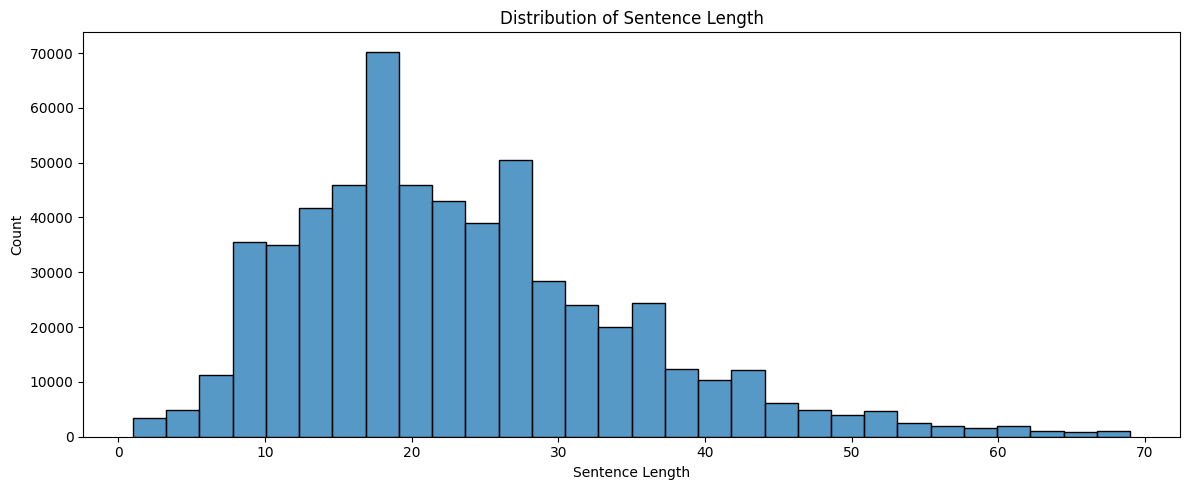

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
"""Now that we have all of our features we need, let's visualize them so we get an idea of what the data looks like."""

#First let's look at average sentence length
filter_sentence = data_features['word_count'] < 70
filtered_length = data_features[filter_sentence]

plt.figure(figsize=(12,5))
sns.histplot(filtered_length['word_count'], bins = 30)
plt.title('Distribution of Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




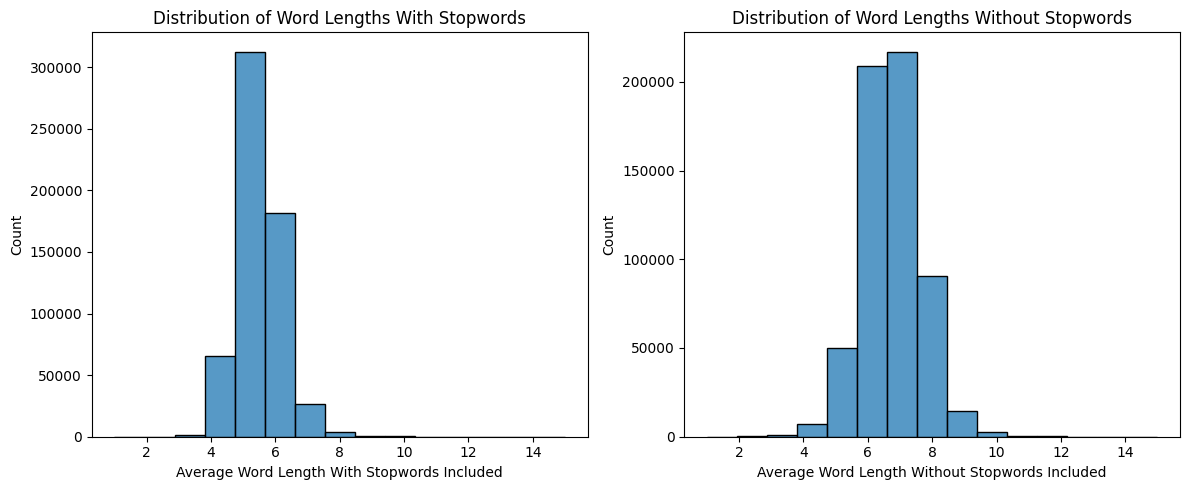

In [248]:
#Now let's look at average word length with and without stopwords
filter_for_words_stopwords = data_features['avg_word_len_with_stopwords'] <= 15 #limit the words to 15 characters to make the graphs look nicer
filtered_words_stopwords = data_features[filter_for_words_stopwords]

filter_for_words = data_features['avg_word_len_no_stopwords'] <= 15
filtered_words = data_features[filter_for_words]


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(filtered_words_stopwords['avg_word_len_with_stopwords'], bins = 15)
plt.xlabel('Average Word Length With Stopwords Included')
plt.ylabel('Count')
plt.title('Distribution of Word Lengths With Stopwords')

plt.subplot(1,2,2)
sns.histplot(filtered_words['avg_word_len_no_stopwords'], bins = 15)
plt.title('Distribution of Word Lengths Without Stopwords')
plt.xlabel('Average Word Length Without Stopwords Included')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

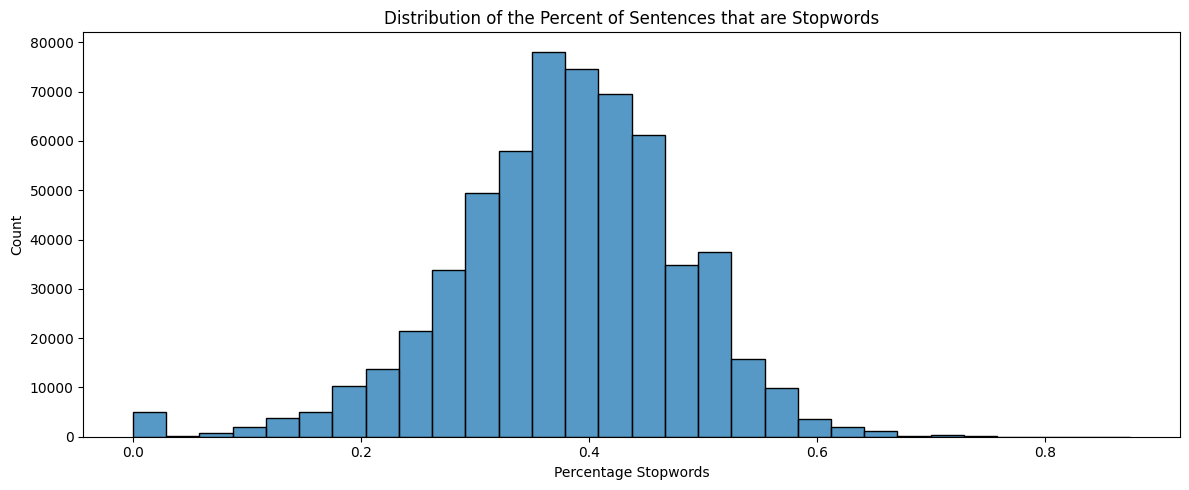

In [249]:
#Let's visualize the percentage of sentences that are stopwords
plt.figure(figsize=(12,5))
sns.histplot(data_features['percent_stopwords'], bins = 30)
plt.title('Distribution of the Percent of Sentences that are Stopwords')
plt.xlabel('Percentage Stopwords')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

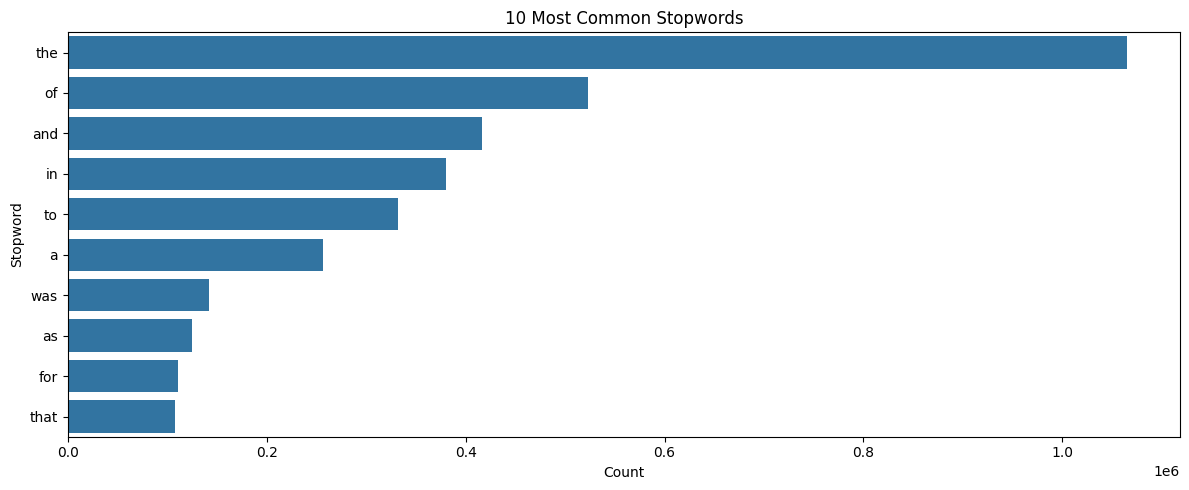

In [250]:
#Let's look at the most common stopwords

list_of_lists = data_features['all_stopwords'].to_list() #grab all values in the column 

words_lists = [str(sublist).split() for sublist in list_of_lists if pd.notna(sublist)] #split every value in the column 
flat_list = [word.lower() for sublist in words_lists for word in sublist if word != ''] #grab each word from each value in the column

stopwords_counts = Counter(flat_list) #count all words 
top_stopwords = stopwords_counts.most_common(10) #ten most common words 
stopwords_df = pd.DataFrame(top_stopwords, columns=['Stopword', 'Count']) #make a df for easy plotting  

plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Stopword', data=stopwords_df)
plt.title('10 Most Common Stopwords')
plt.xlabel('Count')
plt.ylabel('Stopword')
plt.tight_layout()
plt.show()

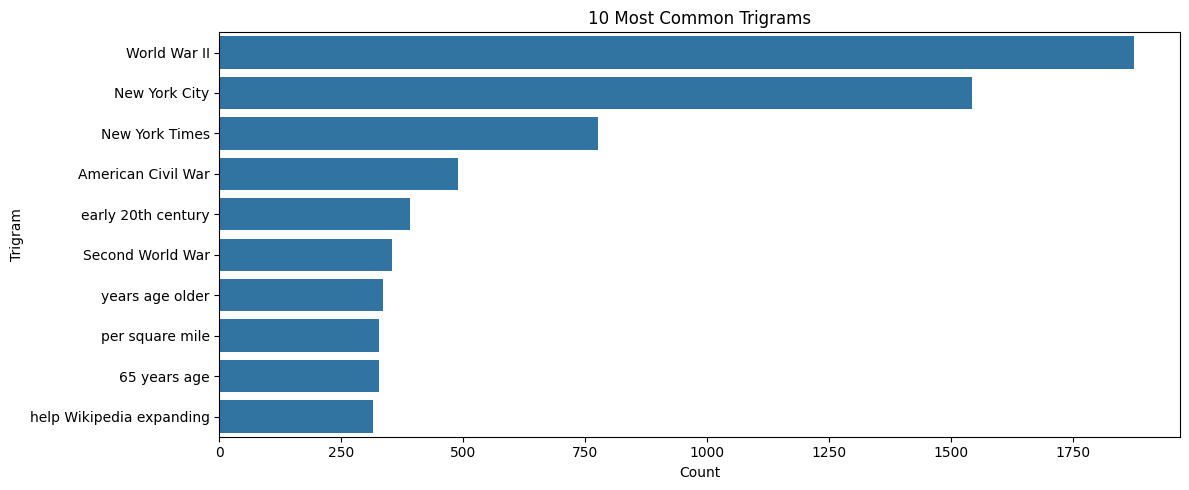

In [251]:
#Let's plot the most common trigrams before and after cleaning the text
from ast import literal_eval

data_features['trigrams_extracted'] = data_features['trigrams_extracted'].apply(literal_eval) #the trigrams are read as a string from the csv file, this converts them back to their true data type 

all_trigrams = [trigram for trigrams_list in data_features['trigrams_extracted'] for trigram in trigrams_list] #grab each trigram from the column 

trigram_counts = Counter(all_trigrams) #count them
top = trigram_counts.most_common(10) #ten most common
top_df = pd.DataFrame(top, columns=['Trigram', 'Count']) #make df for easy plotting 


plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Trigram', data=top_df)
plt.title('10 Most Common Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.tight_layout()
plt.show()

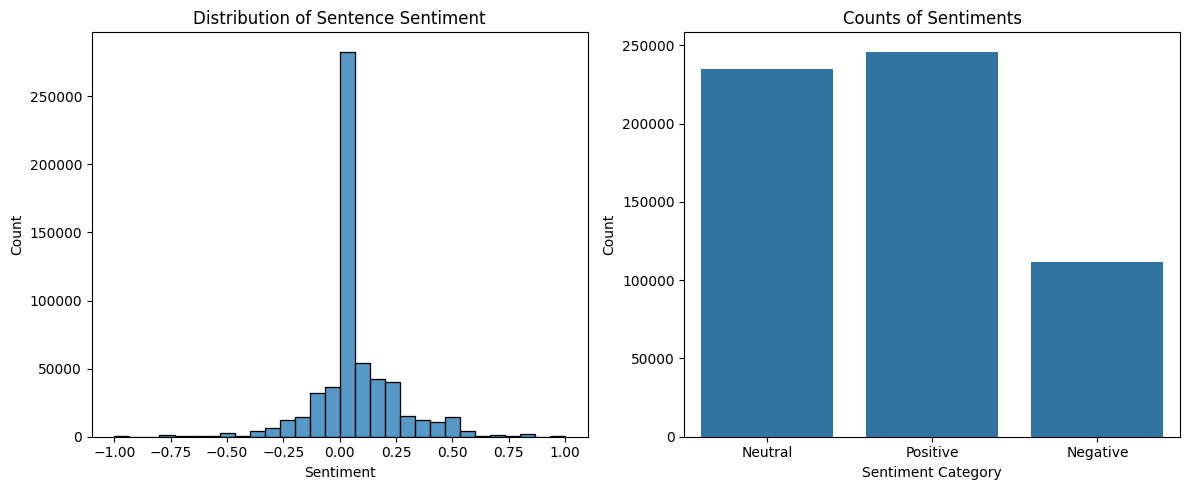

In [252]:
#We will now look at the sentiment analysis of our text 
all_sentiments = [value for value in data_features['sentiment_category']] #grab every sentiment value
sentiment_counts = Counter(all_sentiments) #count them 
sentiment_df = pd.DataFrame.from_dict(sentiment_counts, orient='index', columns=['Count']).reset_index() #make df for easy plotting

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data_features['sentiment'], bins = 30)
plt.title('Distribution of Sentence Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.barplot(x='index', y='Count', data=sentiment_df)
plt.title('Counts of Sentiments')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [253]:
#Because we are reading our data in from a csv file, some data types are read as a string instead of their true type. This occurs with the tag distribution dictionary. Let's convert it back to a dictionary to make the visualization easier. 
list_of_strings =  data_features['tag_distribution'].to_list()
list_of_dicts = [literal_eval(string) for string in list_of_strings]

df = pd.json_normalize(list_of_dicts) #convert the list of dictionaries to a dataframe for easy plotting

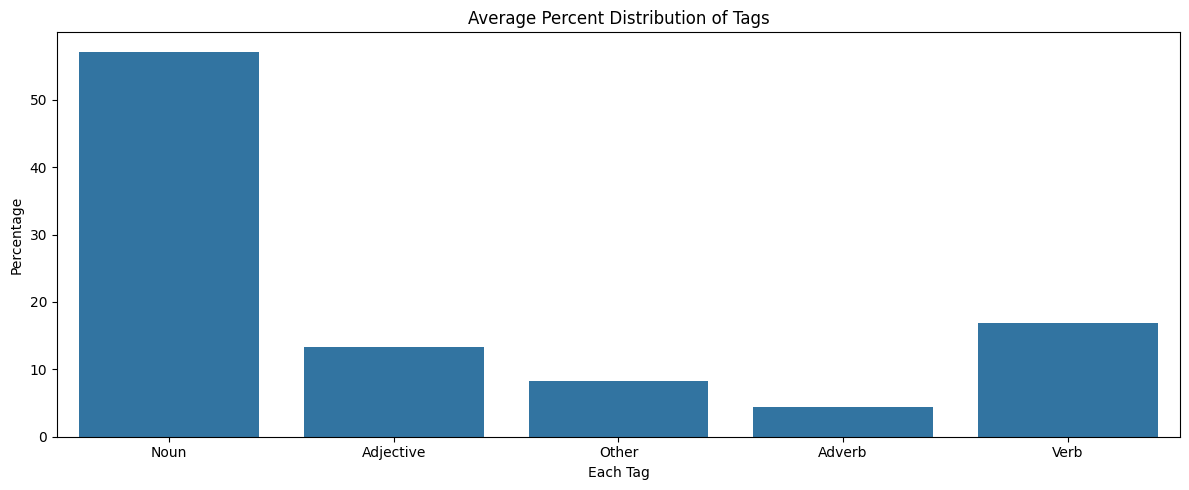

In [254]:
#Now let's visualize the breakdown of pos tags in our sentences
avg_values = df.mean()

plt.figure(figsize=(12,5))
sns.barplot(x=avg_values.index, y=avg_values.values)
plt.title('Average Percent Distribution of Tags')
plt.xlabel('Each Tag')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

We have gathered data, cleaned the data, explored and visualized the data, so now let's use it. We are going to make a model that will predict the next word of a trigram given the first two words. Then use this to predict the next word of the sentence iteratively three times. This will give us three words predicted at the end of the sentences based on the last trigram in the sentence. This is not as effective as using the entire sentence as context, but it is still a good demonstration of using data to create a model. 

In [255]:
from nltk import ngrams
from nltk.probability import FreqDist, ConditionalFreqDist
from sklearn.model_selection import train_test_split
import pandas as pd

train_tokens = [nltk.word_tokenize(sentence) for sentence in data_features['no_punct']] #tokenize all the words in our data 
train_trigrams = list(ngrams([word for sentence_tokens in train_tokens for word in sentence_tokens], 3)) #create trigrams from all data. I know we already have all the trigrams in a column, but this was easy to implement and didn't take long to perform

train_freq_dist = FreqDist(train_trigrams) # Create frequency distributions for the training set
train_cond_freq_dist = ConditionalFreqDist(((trigram[0], trigram[1]), trigram[2]) for trigram in train_trigrams) #this will create a distribution of frequencies based on the words in a trigram

def predict_last_trigram(beginning, cond_freq_dist): # Function to predict the last word of a trigram given the first two words
    beginning_tokens = nltk.word_tokenize(beginning)
    last_trigram = tuple(beginning_tokens[-2:])
    print(last_trigram)
    predicted_word = cond_freq_dist[last_trigram].max() #grab the word with the highest frequency 
    return predicted_word


def predictor(sentence): #this function iterates through three times to essentially predict three words in a row based on the last two words before each predicted word
    predicted_words = []
    for i in range(3):
        predicted_last_trigram = predict_last_trigram(sentence, train_cond_freq_dist)
        str(predicted_last_trigram)
        sentence += ' ' + str(predicted_last_trigram)
        predicted_words.append(predicted_last_trigram) #put all the predicted words into one string
    return predicted_words



In [256]:

data_features['beginning'] = data_features['no_punct'].apply(lambda x: ' '.join(x.split()[:-3])) #create a new column that has all but the last three words on the original column

def predict_last_trigram(beginning, cond_freq_dist):
    beginning_tokens = nltk.word_tokenize(beginning)
    last_trigram = tuple(beginning_tokens[-2:])

    if last_trigram in cond_freq_dist: #check if the condition exists in the ConditionalFreqDist
        freq_dist = cond_freq_dist[last_trigram]

        if len(freq_dist) > 0:  #check if the FreqDist has at least one sample
            predicted_word = freq_dist.max()
            return predicted_word
        else: #if the FreqDist is empty, return unknown
            return "Unknown" 
    else: #if the condition doesn't exist, return unknown
        return "Unknown"



def predictor(sentence):
    predicted_words = []
    for i in range(3):
        predicted_last_trigram = predict_last_trigram(sentence, train_cond_freq_dist)
        sentence += ' ' + str(predicted_last_trigram)
        predicted_words.append(predicted_last_trigram)
    return predicted_words


data_features['prediction'] = data_features['beginning'].apply(predictor) #create a new column which contains the predictions

In [257]:
data_features.sample(5)

,original_text,no_punct,no_stopwords,lemmatized,word_count,avg_word_len_with_stopwords,avg_word_len_no_stopwords,percent_stopwords,trigrams,trigrams_extracted,tag_distribution,sentiment,sentiment_category,all_stopwords,beginning,prediction
69883,"In June, he was assigned to the USS De Grasse (ID-1217) at Fort Schuyler in New York, where he worked as an indoctrinator.",In June he was assigned to the USS De Grasse ID1217 at Fort Schuyler in New York where he worked as an indoctrinator,June assigned USS De Grasse ID1217 Fort Schuyler New York worked indoctrinator,June assigned USS De Grasse ID1217 Fort Schuyler New York worked indoctrinator,23,4,6,0.478,"[('June', 'assigned', 'USS'), ('assigned', 'USS', 'De'), ('USS', 'De', 'Grasse'), ('De', 'Grasse', 'ID1217'), ('Grasse', 'ID1217', 'Fort'), ('ID1217', 'Fort', 'Schuyler'), ('Fort', 'Schuyler', 'New'), ('Schuyler', 'New', 'York'), ('New', 'York', 'worked'), ('York', 'worked', 'indoctrinator')]","[June assigned USS, assigned USS De, USS De Grasse, De Grasse ID1217, Grasse ID1217 Fort, ID1217 Fort Schuyler, Fort Schuyler New, Schuyler New York, New York worked, York worked indoctrinator]","{'Noun': 83.333, 'Adjective': 0.0, 'Other': 0.0, 'Adverb': 0.0, 'Verb': 16.667}",0.136364,Positive,In he was to the at in where he as an,In June he was assigned to the USS De Grasse ID1217 at Fort Schuyler in New York where he worked,"[as, a, result]"
291212,"[5] The Dutch West India Company allowed New Netherlanders to trade slaves from Angola for ""seasoned"" African slaves from the Dutch West Indies, particularly Curaçao, who sold for more than other slaves.",The Dutch West India Company allowed New Netherlanders to trade slaves from Angola for seasoned African slaves from the Dutch West Indies particularly Curaçao who sold for more than other slaves,Dutch West India Company allowed New Netherlanders trade slaves Angola seasoned African slaves Dutch West Indies particularly Curaçao sold slaves,Dutch West India Company allowed New Netherlanders trade slave Angola seasoned African slave Dutch West Indies particularly Curaçao sold slave,32,5,6,0.344,"[('Dutch', 'West', 'India'), ('West', 'India', 'Company'), ('India', 'Company', 'allowed'), ('Company', 'allowed', 'New'), ('allowed', 'New', 'Netherlanders'), ('New', 'Netherlanders', 'trade'), ('Netherlanders', 'trade', 'slaves'), ('trade', 'slaves', 'Angola'), ('slaves', 'Angola', 'seasoned'), ('Angola', 'seasoned', 'African'), ('seasoned', 'African', 'slaves'), ('African', 'slaves', 'Dutch'), ('slaves', 'Dutch', 'West'), ('Dutch', 'West', 'Indies'), ('West', 'Indies', 'particularly'), ('Indies', 'particularly', 'Curaçao'), ('particularly', 'Curaçao', 'sold'), ('Curaçao', 'sold', 'slaves')]","[Dutch West India, West India Company, India Company allowed, Company allowed New, allowed New Netherlanders, New Netherlanders trade, Netherlanders trade slaves, trade slaves Angola, slaves Angola seasoned, Angola seasoned African, seasoned African slaves, African slaves Dutch, slaves Dutch West, Dutch West Indies, West Indies particularly, Indies particularly Curaçao, particularly Curaçao sold, Curaçao sold slaves]","{'Noun': 75.0, 'Adjective': 5.0, 'Other': 0.0, 'Adverb': 5.0, 'Verb': 15.0}",0.154672,Positive,The to from for from the who for more than other,The Dutch West India Company allowed New Netherlanders to trade slaves from Angola for seasoned African slaves from the Dutch West Indies particularly Curaçao who sold for more,"[than, a, year]"
476786,[1] The United Nations announced that 1975 was going to be International Women's Year.,The United Nations announced that 1975 was going to be International Womens Year,United Nations announced 1975 going International Womens Year,United Nations announced 1975 going International Womens Year,14,5,7,0.357,"[('United', 'Nations', 'announced'), ('Nations', 'announced', '1975'), ('announced', '1975', 'going'), ('1975', 'going', 'International'), ('going', 'International', 'Womens'), ('International', 'Womens', 